In [16]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# Parameters we set
num_spec = 10
window_size = 100
stride = 10


phrase_repeats = 5
num_songs = 10
radius_value = 0.01
num_syllables = 10

folderpath = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'
folderpath_song = f'{folderpath}num_songs_{num_songs}_num_syllables_{num_syllables}_phrase_repeats_{phrase_repeats}_radius_{radius_value}/'

mean_colors_per_minispec = np.load(f'{folderpath_song}mean_colors_per_minispec.npy')

stacked_windows = np.load(f'{folderpath_song}stacked_windows.npy')
# stacked_window_times = np.load(f'{folderpath_song}stacked_window_times.npy')
stacked_labels_for_window = np.load(f'{folderpath_song}labels_for_window.npy')

if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

# Let's shuffle the stacked_windows and stacked_labels_for_window

# Shuffle the indices of stacked_windows
shuffled_indices = np.random.permutation(stacked_windows.shape[0])

# Shuffle array1 using the shuffled indices
stacked_windows = stacked_windows[shuffled_indices,:]

# Shuffle array2 using the same shuffled indices
stacked_labels_for_window = stacked_labels_for_window[shuffled_indices,:]

In [17]:
# %% Define neural network

class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=(5, 5), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64*1*36, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # x = self.relu(x)
        x = self.fc2(x)
        # x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

cnn_model = TweetyNetCNN()
cnn_model = cnn_model.double().to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()



In [18]:
stacked_windows_tensor = stacked_windows.copy()
stacked_windows_tensor.shape = (stacked_windows.shape[0], 1, 100, 40)
stacked_windows_tensor = torch.tensor(stacked_windows_tensor).double()


actual_labels = np.max(stacked_labels_for_window, axis=1)
actual_labels = torch.tensor(actual_labels)

# Determine the split point for testing data
split_point = int(0.7 * stacked_windows_tensor.shape[0])

# Split the data into training and testing sets
train_data, test_data = stacked_windows_tensor[:split_point,:,:,:], stacked_windows_tensor[split_point:,:,:,:]
train_labels, test_labels = actual_labels[:split_point], actual_labels[split_point:]

# Convert the numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data)
test_data_tensor = torch.tensor(test_data)
train_labels_tensor = torch.tensor(train_labels)  # Assuming integer labels
test_labels_tensor = torch.tensor(test_labels)

# Create TensorDatasets for training and testing sets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Define batch size for DataLoader
batch_size = 64

# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle test data


# Choose a random 64 indices from our total data

# batch_indices = np.random.randint(0, stacked_windows_tensor.shape[0], batch_size)

# x = stacked_windows_tensor[batch_indices, :,:,:]
# y = actual_labels[batch_indices]

# # Create a TensorDataset to combine features and labels
# dataset = TensorDataset(stacked_windows_tensor, actual_labels)

# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# # Extract the first batch
# for batch in train_loader:
#     first_batch = batch
#     break  # Exit the loop after the first iteration

# x = first_batch[0]
# y = first_batch[1]

positive_sample_index_list = []
negative_samples_indices_list = []


unique_syllables = torch.unique(actual_labels)

indices_dict = {int(element): np.where(actual_labels == element)[0] for element in unique_syllables}
num_negative_samples_each = 25


/tmp/ipykernel_19394/3920792282.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(train_data)
/tmp/ipykernel_19394/3920792282.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(test_data)
/tmp/ipykernel_19394/3920792282.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_labels)  # Assuming integer labels
/tmp/ipykernel_19394/3920792282.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

In [19]:
# %% Train Neural network 

cnn_model.train()
num_epoch = 1
mean_batch_loss_per_epoch_list = []
for epoch in np.arange(num_epoch):
    total_batch_loss_list = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        batch_loss = 0
        for anchor_index in np.arange(data.shape[0]):
            anchor_label = targets[anchor_index]
            # Sample a positive sample from our total dataset
            indices_of_positve_samples = torch.where(actual_labels == anchor_label)[0]
            positive_sample_index = torch.randint(0, indices_of_positve_samples.shape[0], size=(1,))
            positive_sample_index_list.append(positive_sample_index.item())

            # Sample negative samples from our total dataset. We will use a 
            # weighted probability distribution. There will be a 0.0001 probability
            # that we will sample from the positive class and a (1-0.001)/(K-1)
            # probability that we sample from the remaining K-1 classes

            # Create a tensor with custom probabilities
            epsilon = 0.0001
            probs = torch.zeros((1, unique_syllables.shape[0]))
            probs[:,:] = (1-epsilon)/(probs.shape[1]-1)
            probs[:,int(anchor_label)] = epsilon


            # Number of samples to generate
            num_samples = unique_syllables.shape[0] - 1

            # Sample indices based on the custom probabilities
            sampled_labels = torch.multinomial(probs, num_samples, replacement=False)

            # Now let's randomly sample an index value from each sampled label

            random_samples = {key: np.random.choice(values, num_negative_samples_each) for key, values in indices_dict.items() if key in sampled_labels}
            indices_of_negative_samples = np.array(list(random_samples.values()))
            negative_samples_indices_list.append(indices_of_negative_samples)
            a = np.stack(indices_of_negative_samples)
            indices_of_negative_samples = np.stack(indices_of_negative_samples).reshape(a.shape[0]*a.shape[1],)


            # Now let's extract the positive and negative samples' spectrogram 
            # slices

            positive_sample = stacked_windows_tensor[positive_sample_index, :,:,:]
            negative_samples = stacked_windows_tensor[indices_of_negative_samples, :,:,:]

            dat = torch.concatenate((positive_sample, negative_samples))

            artificial_labels = torch.zeros((1,1 + (unique_syllables.shape[0]-1)*num_negative_samples_each))
            artificial_labels[:,0] = 1

            # Get the number of rows in the tensors
            num_rows = dat.shape[0]

            # Generate a random permutation of indices
            shuffled_indices_pseudo = torch.randperm(num_rows)

            # Shuffle both tensors based on the same indices
            dat = dat[shuffled_indices_pseudo,:,:,:].to(device)
            artificial_labels = artificial_labels[:,shuffled_indices_pseudo].to(device)

            pred_probs = cnn_model(dat)

            # h_t = 1/(1+torch.exp(-1*(torch.log(pred_probs) - torch.log(probs).T)))
            # torch.sum(artificial_labels.T*torch.log(h_t) + (1-artificial_labels.T)*torch.log(h_t))

            loss = criterion(pred_probs, artificial_labels.T.double())
            batch_loss+=loss

        total_batch_loss_list.append(batch_loss.item())
        # print(f'Batch Loss: {batch_loss.item():.4f}')
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    mean_batch_loss_per_epoch = np.mean(total_batch_loss_list)
    mean_batch_loss_per_epoch_list.append(mean_batch_loss_per_epoch)
    print("=================================================================")
    print(f'Epoch {epoch}, Mean Batch Loss: {mean_batch_loss_per_epoch:.4f}')
    print("=================================================================")

    

Epoch 0, Mean Batch Loss: 2.2678


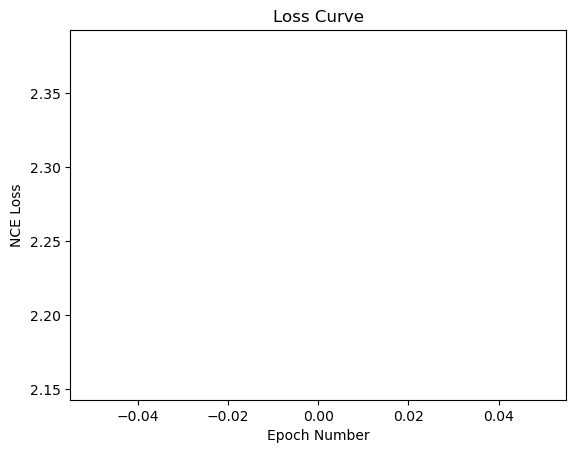

In [20]:
plt.figure()
plt.title("Loss Curve")
plt.xlabel("Epoch Number")
plt.ylabel("NCE Loss")
plt.plot(mean_batch_loss_per_epoch_list)
plt.show()

Push our training data through the model to obtain an embedding

In [21]:
cnn_model.to('cpu').eval()
model_embedding_arr = torch.empty((0,1000)).to('cpu')
for batch_idx, (data, targets) in enumerate(train_loader):
    x = cnn_model.conv1(data.to('cpu'))
    x = cnn_model.relu(x)
    x = cnn_model.pool1(x)
    x = cnn_model.conv2(x)
    x = cnn_model.relu(x)
    x = cnn_model.pool2(x)
    x = torch.flatten(x, 1)
    x = cnn_model.fc1(x)
    model_embedding_arr = torch.concatenate((model_embedding_arr, x))

In [22]:
model_embedding_arr.shape

torch.Size([17811, 1000])

Do a UMAP on our training data's embedding

In [23]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(model_embedding_arr.cpu().detach().numpy())

In [24]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pandas as pd

In [26]:
shuffled_indices[:split_point]

array([ 9552,  7910, 12812, ..., 23866,  4790, 14288])

In [27]:
mean_colors_per_minispec_training = mean_colors_per_minispec[shuffled_indices[:split_point],:]
mean_colors_per_minispec_testing = mean_colors_per_minispec[shuffled_indices[split_point:],:]

In [30]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap_of_TweetyNet_Embed_NCE.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_umap, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_umap[:,0], y = embedding_umap[:,1], colors=mean_colors_per_minispec_training))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(spec_df.shape[0]):
#     source.data['image'].append(f'{folderpath_song}/Plots/Window_Plots/Window_{shuffled_indices[split_point:]}.png')

show(p)

# save(p)


In [31]:
shuffled_indices[:split_point]

array([ 9552,  7910, 12812, ..., 23866,  4790, 14288])

Apply UMAP to the raw training data spectrograms

In [33]:
reducer_umap_alone = umap.UMAP()
embedding_umap_alone = reducer_umap_alone.fit_transform(train_data_tensor.cpu().detach().numpy().reshape(train_data_tensor.shape[0],-1))


In [34]:
train_data_tensor.cpu().detach().numpy().reshape(train_data_tensor.shape[0],-1).shape

(17811, 4000)

In [35]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap_alone.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_umap_alone, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_umap_alone[:,0], y = embedding_umap_alone[:,1], colors=mean_colors_per_minispec_training))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(spec_df.shape[0]):
#     source.data['image'].append(f'{songpath}/Plots/Window_Plots/Window_{shuffled_indices[split_point:[i]]}.png')

show(p)

# save(p)

Push our testing data through the model

In [36]:
cnn_model.to('cpu').eval()
model_embedding_arr_testing = torch.empty((0,1000)).to('cpu')
for batch_idx, (data, targets) in enumerate(test_loader):
    x = cnn_model.conv1(data.to('cpu'))
    x = cnn_model.relu(x)
    x = cnn_model.pool1(x)
    x = cnn_model.conv2(x)
    x = cnn_model.relu(x)
    x = cnn_model.pool2(x)
    x = torch.flatten(x, 1)
    x = cnn_model.fc1(x)
    model_embedding_arr_testing = torch.concatenate((model_embedding_arr_testing, x))

In [37]:
import umap
reducer = umap.UMAP()
embedding_umap_testing = reducer.fit_transform(model_embedding_arr_testing.cpu().detach().numpy())

In [38]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap_of_TweetyNet_Embed_NCE_testing.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_umap_testing, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_umap_testing[:,0], y = embedding_umap_testing[:,1], colors=mean_colors_per_minispec_testing))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
# source.data['image'] = []
# for i in np.arange(spec_df.shape[0]):
#     source.data['image'].append(f'{songpath}/Plots/Window_Plots/Window_{i}.png')

show(p)

# save(p)


In [39]:
test_data.shape

torch.Size([7634, 1, 100, 40])

In [40]:
train_data.shape

torch.Size([17811, 1, 100, 40])

In [41]:
7634 + 17811

25445

In [42]:
7634/25445

0.3000196502259776

Let's quantify how well the model classifies syllables

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of SVC with a linear kernel
svc_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svc_classifier.fit(embedding_umap_testing, test_labels)

# Make predictions on the test data
y_pred = svc_classifier.predict(embedding_umap_testing)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.97446


: 